In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from keras.layers import Input, Dense, Dropout
from keras.models import Model, Sequential
from sklearn.metrics import roc_curve, auc,roc_auc_score
from sklearn.model_selection import train_test_split
import pandas as pd
from matplotlib import gridspec
from scipy import stats
from sklearn import preprocessing
import os
os.environ["CUDA_VISIBLE_DEVICES"]="2"

# restart kernel
# config = tf.ConfigProto()
# config.gpu_options.allow_growth = True

Using TensorFlow backend.
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/anaconda3/envs/shared_env/l

In [3]:
datafile="/data0/users/bpnachman/Gaia/GD1-circle-140-30-15.pkl"
gaiadata=np.load(datafile,allow_pickle=True)
gaiadata2=np.array(gaiadata[['pmdec','pmra','dec','ra','phot_g_mean_mag','phot_bp_mean_mag','phot_rp_mean_mag', 'streammask']].astype('float32'))
gaiadata2 = np.vstack([gaiadata2[:,0].T,
           gaiadata2[:,1].T,
           gaiadata2[:,2].T,
           gaiadata2[:,3].T,
           (gaiadata2[:,5]-gaiadata2[:,6]).T,
           gaiadata2[:,4].T, 
            gaiadata2[:,7].T]).T
gaiadata2 = gaiadata2[np.sum(np.isnan(gaiadata2),axis=1)==0]
center_dec=0.5*(np.max(gaiadata2[:,2])+np.min(gaiadata2[:,2]))
center_ra=0.5*(np.max(gaiadata2[:,3])+np.min(gaiadata2[:,3]))
radius=np.sqrt((gaiadata2[:,2]-center_dec)**2+(gaiadata2[:,3]-center_ra)**2)
gaiadata2=gaiadata2[radius<15]
np.random.shuffle(gaiadata2)

In [4]:
gaiadata3=np.array(gaiadata[gaiadata['streammask']==1][['pmdec','pmra','dec','ra','phot_g_mean_mag','phot_bp_mean_mag','phot_rp_mean_mag', 'streammask']].astype('float32'))
gaiadata3 = np.vstack([gaiadata3[:,0].T,
           gaiadata3[:,1].T,
           gaiadata3[:,2].T,
           gaiadata3[:,3].T,
           (gaiadata3[:,5]-gaiadata3[:,6]).T,
           gaiadata3[:,4].T, 
           gaiadata3[:, 7].T]).T
gaiadata3 = gaiadata3[np.sum(np.isnan(gaiadata3),axis=1)==0]
radius=np.sqrt((gaiadata3[:,2]-center_dec)**2+(gaiadata3[:,3]-center_ra)**2)
gaiadata3=gaiadata3[radius<15]
np.random.shuffle(gaiadata3)

In [5]:
gaiadata2_no_gd1 = np.array(gaiadata[gaiadata['streammask']==0][['pmdec','pmra','dec','ra','phot_g_mean_mag','phot_bp_mean_mag','phot_rp_mean_mag', 'streammask']].astype('float32'))
gaiadata2_no_gd1 = np.vstack([gaiadata2_no_gd1[:,0].T,
           gaiadata2_no_gd1[:,1].T,
           gaiadata2_no_gd1[:,2].T,
           gaiadata2_no_gd1[:,3].T,
           (gaiadata2_no_gd1[:,5]-gaiadata2_no_gd1[:,6]).T,
           gaiadata2_no_gd1[:,4].T, 
            gaiadata2_no_gd1[:, 7].T]).T
gaiadata2_no_gd1 = gaiadata2_no_gd1[np.sum(np.isnan(gaiadata2_no_gd1),axis=1)==0]
radius=np.sqrt((gaiadata2_no_gd1[:,2]-center_dec)**2+(gaiadata2_no_gd1[:,3]-center_ra)**2)
gaiadata2_no_gd1=gaiadata2_no_gd1[radius<15]
np.random.shuffle(gaiadata2_no_gd1)                            

In [6]:
gaiadata.keys()

Index(['source_id', 'ra', 'ra_error', 'dec', 'dec_error', 'parallax',
       'parallax_error', 'parallax_over_error', 'pmra', 'pmra_error', 'pmdec',
       'pmdec_error', 'phot_g_mean_mag', 'phot_bp_mean_mag',
       'phot_rp_mean_mag', 'bp_rp', 'radial_velocity', 'radial_velocity_error',
       'teff_val', 'streammask'],
      dtype='object')

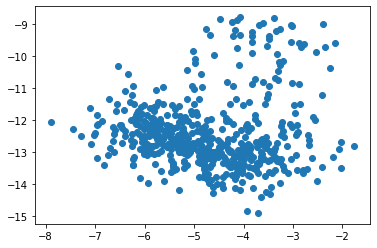

In [7]:
plt.scatter(gaiadata3[:,1],gaiadata3[:,0])

Text(0, 0.5, '$\\mu_\\delta$ [$\\mu$as/year]')

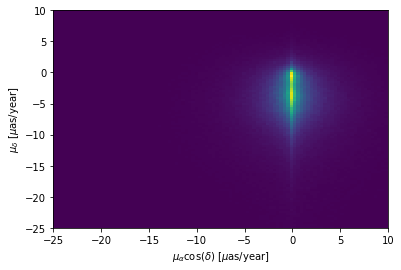

In [8]:
_,_,_,_=plt.hist2d(gaiadata2[:,1]*np.cos(gaiadata2[:,2]),gaiadata2[:,0],bins=[np.linspace(-25,10,100),np.linspace(-25,10,100)])
plt.xlabel(r"$\mu_\alpha\cos(\delta)$ [$\mu$as/year]")
plt.ylabel(r"$\mu_\delta$ [$\mu$as/year]")

Text(0, 0.5, '$\\delta$ [degrees]')

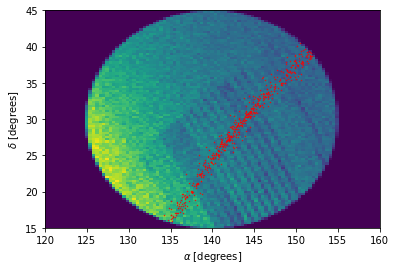

In [9]:
_,_,_,_=plt.hist2d(gaiadata2[:,3],gaiadata2[:,2],bins=[np.linspace(120,160,100),np.linspace(15,45,100)])
plt.scatter(gaiadata3[:,3],gaiadata3[:,2],color='red',s=0.2)
plt.xlabel(r"$\alpha$ [degrees]")
plt.ylabel(r"$\delta$ [degrees]")

Text(0, 0.5, '$\\delta$ [degrees]')

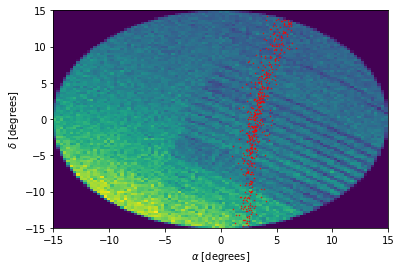

In [10]:
X = gaiadata2[:,3]-center_ra
Y = gaiadata2[:,2]-center_dec

Xs = gaiadata3[:,3]-center_ra
Ys = gaiadata3[:,2]-center_dec

theta = -0.5
Xr = X*np.cos(theta) + Y*np.sin(theta)
Yr = -X*np.sin(theta) + Y*np.cos(theta)
Xsr = Xs*np.cos(theta) + Ys*np.sin(theta)
Ysr = -Xs*np.sin(theta) + Ys*np.cos(theta)

_,_,_,_=plt.hist2d(Xr,Yr,bins=[np.linspace(-15,15,100),np.linspace(-15,15,100)])
plt.scatter(Xsr,Ysr,color='red',s=0.2)
plt.xlabel(r"$\alpha$ [degrees]")
plt.ylabel(r"$\delta$ [degrees]")

Text(0.5, 0, 'Rotated $\\delta$-$\\alpha$ space')

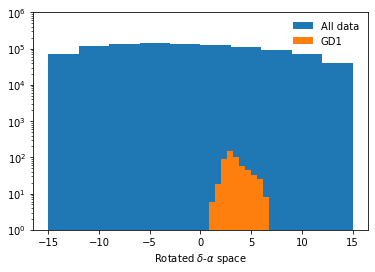

In [11]:
plt.hist(Xr,label="All data")
plt.hist(Xsr,label="GD1")
plt.yscale("log")
plt.legend(frameon=False)
plt.ylim([1,1e6])
plt.xlabel(r"Rotated $\delta$-$\alpha$ space")

Text(0.5, 0, '$\\mu_\\alpha\\cos(\\delta)$ [$\\mu$as/year]')

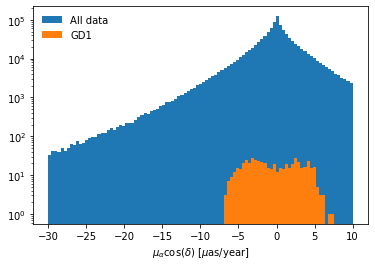

In [12]:
_,_,_=plt.hist(gaiadata2[:,1]*np.cos(gaiadata2[:,2]),bins=np.linspace(-30,10,100),label="All data")
_,_,_=plt.hist(gaiadata3[:,1]*np.cos(gaiadata3[:,2]),bins=np.linspace(-30,10,100),label="GD1")
plt.legend(frameon=False)
plt.yscale("log")
plt.xlabel(r"$\mu_\alpha\cos(\delta)$ [$\mu$as/year]")

Text(0.5, 0, '$\\mu_\\delta$ [$\\mu$as/year]')

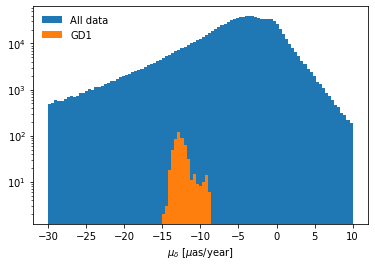

In [13]:
_,_,_=plt.hist(gaiadata2[:,0],bins=np.linspace(-30,10,100),label="All data")
_,_,_=plt.hist(gaiadata3[:,0],bins=np.linspace(-30,10,100),label="GD1")
plt.legend(frameon=False)
plt.yscale("log")
plt.xlabel(r"$\mu_\delta$ [$\mu$as/year]")

In [14]:
def build_data_arrays(SR, SB, GD1, gaiadata2):
    X = SR[:,3]-center_ra
    Y = SR[:,2]-center_dec

    Xb = SB[:,3]-center_ra
    Yb = SB[:,2]-center_dec

    Xs = GD1[:,3]-center_ra
    Ys = GD1[:,2]-center_dec
    
    Xad = gaiadata2[:, 3]-center_ra
    Yad = gaiadata2[:, 2]-center_dec

    SR = np.c_[SR[:,0],SR[:,1],X, Y, SR[:,4],SR[:,5], SR[:,6]]
    SB = np.c_[SB[:,0],SB[:,1],Xb, Yb, SB[:,4],SB[:,5], SB[:,6]]
    GD1 = np.c_[GD1[:,0],GD1[:,1],Xs, Ys, GD1[:,4],GD1[:,5], GD1[:,6]]
    gaiadata2 = np.c_[gaiadata2[:,0],gaiadata2[:,1], Xad, Yad, gaiadata2[:,4],gaiadata2[:,5],gaiadata2[:,6]]
    
    return SR, SB, GD1, gaiadata2

In [15]:
def index_to_xcoord(j):
    return -30 + 40*j/100

In [16]:
threshold_arr_size = 10000

In [17]:
def calc_diff(SR, SB):
    return abs(len(SR) - len(SB))

In [18]:
def find_SR_SB_pointers(pointers, increment, data_arr):
    SR = data_arr[(data_arr[:,0] > pointers[1])*(data_arr[:,0] < pointers[2])]
    SB = data_arr[(data_arr[:,0] > pointers[0])*(data_arr[:,0] < pointers[1]) + (data_arr[:,0] > pointers[2])*(data_arr[:,0] < pointers[3])]

    previous_diff = calc_diff(SR, SB)
    prev_SR, prev_SB = SR, SB
    curr_diff = previous_diff
    bottom_bool = False
    top_bool = True

    while curr_diff <= previous_diff and pointers[3] < end_point:
        previous_diff, prev_SR, prev_SB = curr_diff, SR, SB
        if bottom_bool:
            pointers[0] = max(start_point, pointers[0] - increment)
        else:
            pointers[3] = min(end_point, pointers[3] + increment)
        bottom_bool, top_bool = top_bool, bottom_bool
        SR = data_arr[(data_arr[:,0] > pointers[1])*(data_arr[:,0] < pointers[2])]
        SB = data_arr[(data_arr[:,0] > pointers[0])*(data_arr[:,0] < pointers[1]) + (data_arr[:,0] > pointers[2])*(data_arr[:,0] < pointers[3])]
        curr_diff = calc_diff(SR, SB)

    return prev_SR, prev_SB

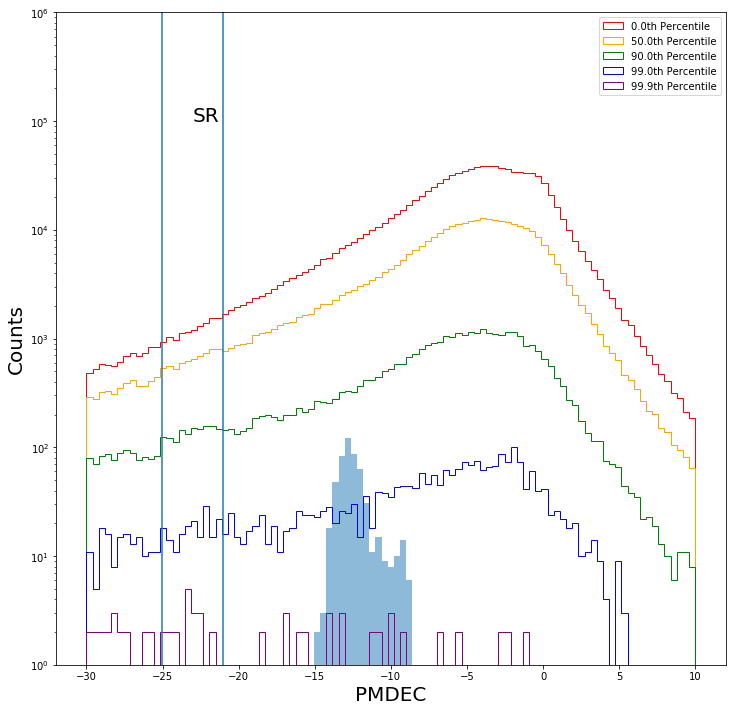

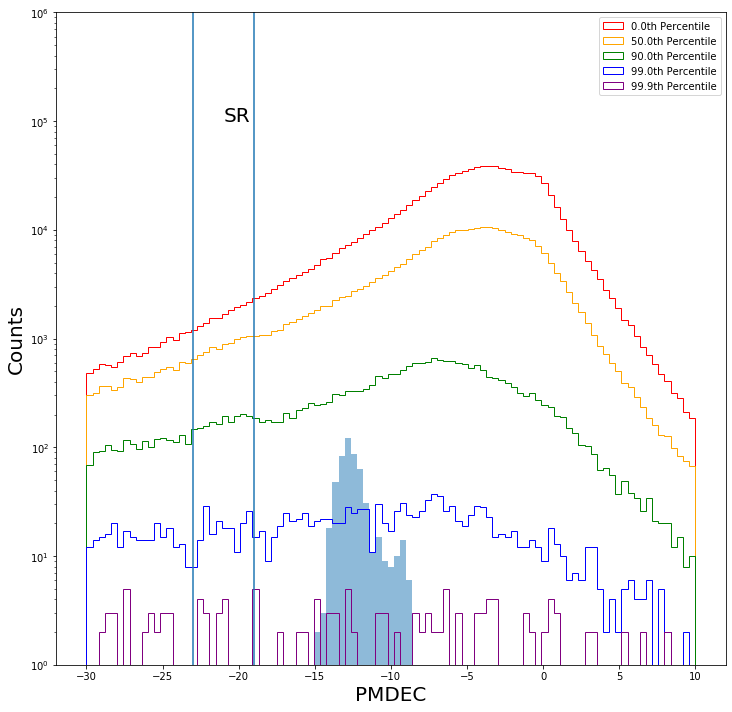

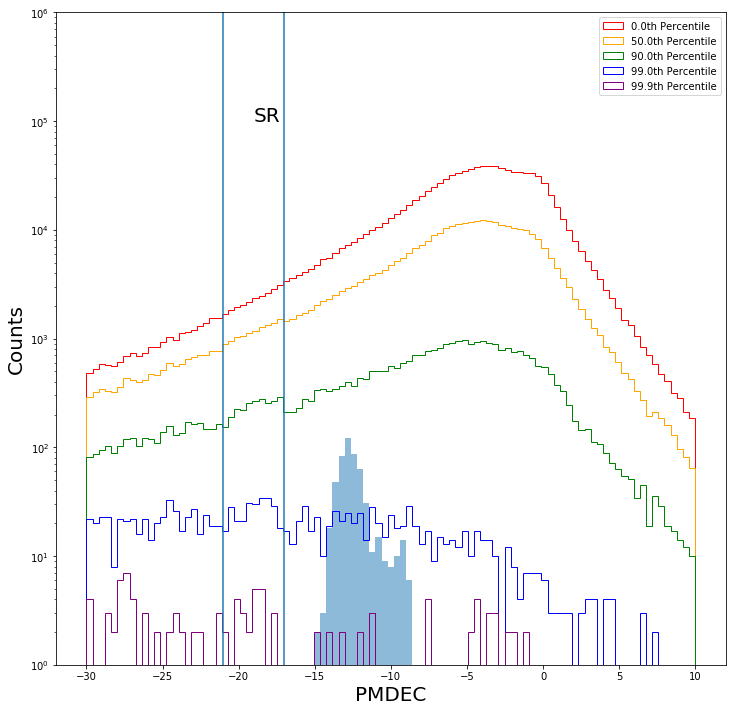

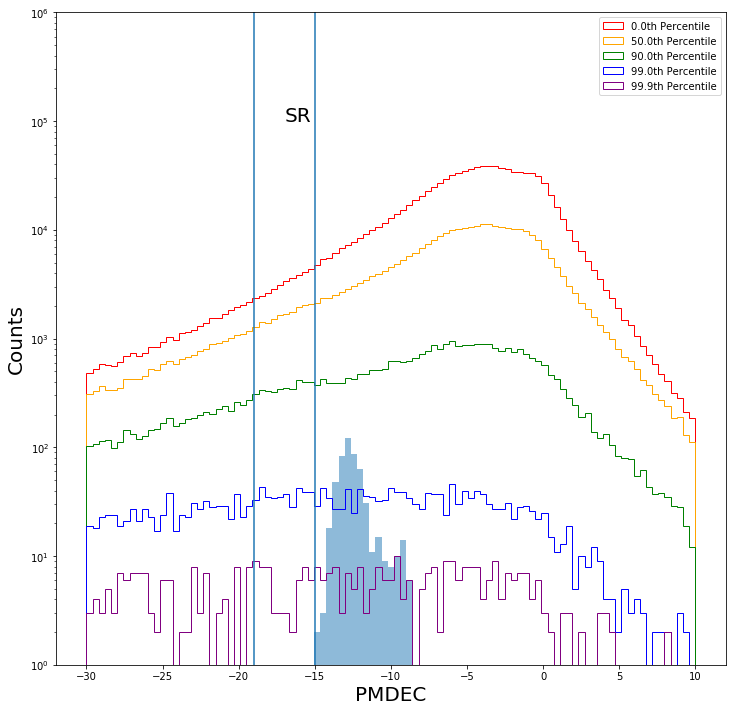

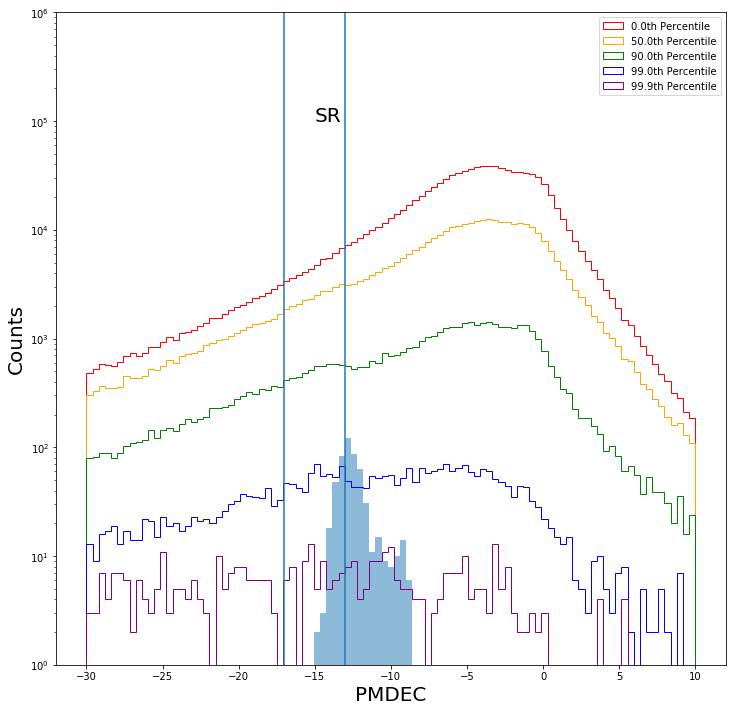

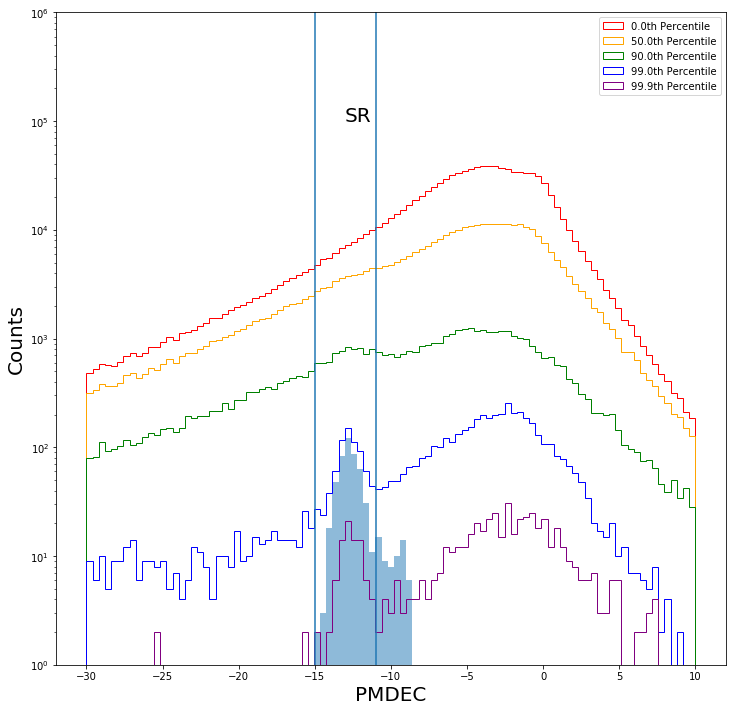

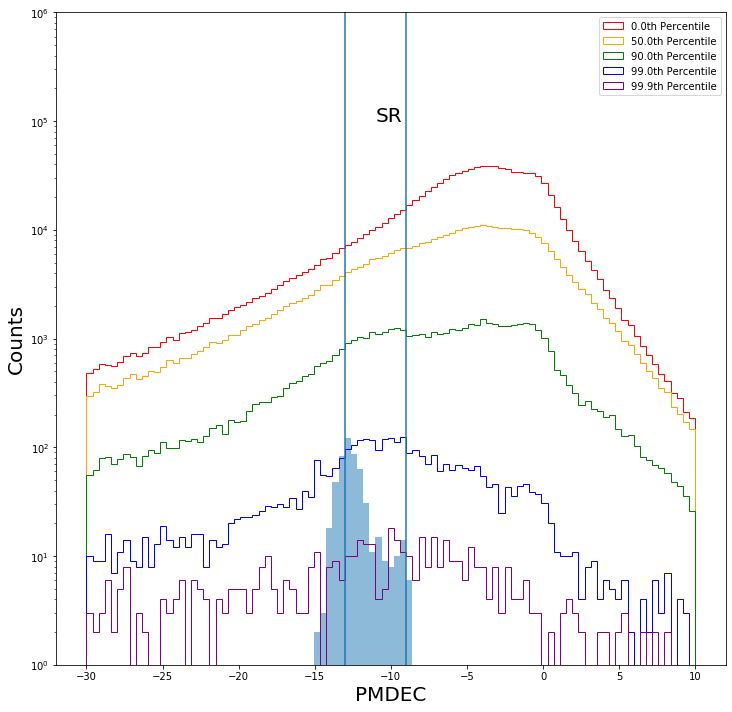

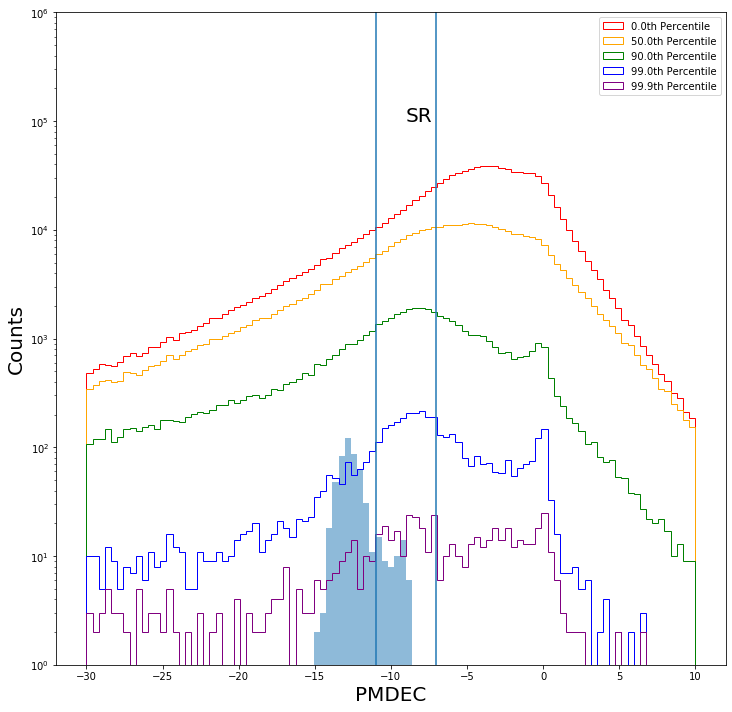

In [31]:
def build_model(SR, SB, stream, num_models, all_data, plot_cuts = False):
    
    X = np.concatenate([SR,SB,stream])
    Y = np.concatenate([np.ones(len(SR)),np.zeros(len(SB)),2.*np.ones(len(stream))])

    myscalar = preprocessing.StandardScaler()
    myscalar.fit(X[:, :6])
    X_scaled = myscalar.transform(X[:,:6])
    all_data_scaled = myscalar.transform(all_data[:, :6])
    all_data_scaled = np.c_[all_data_scaled, all_data[:, 6]]

    X_scaled = np.c_[X_scaled, X[:, 6]]
    stream_scaled = X_scaled[Y==2]
    X_scaled = X_scaled[Y<2]
    Y = Y[Y<2]
    
    X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.5)


    for i in range(num_models):

        model = Sequential()
        model.add(Dense(64, input_dim=5, activation='relu')) 
        model.add(Dense(64, activation='relu'))
        model.add(Dense(64, activation='relu'))
        model.add(Dense(1, activation='sigmoid'))
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        history = model.fit(X_train[:,1:6],Y_train, epochs=20, batch_size=200,validation_data=(X_test[:,1:6],Y_test), verbose = 0) 

        preds = model.predict(X_test[:,1:6], batch_size=int(0.1*len(X_test)))
        preds_all = model.predict(all_data_scaled[:, 1:6]) 
        preds_stream = model.predict(stream_scaled[:,1:6], batch_size=int(0.1*len(stream_scaled)))
        
        cuts = [0.,0.5,0.9,0.99, 0.999]
        bins_cuts = np.zeros((len(cuts), 99))
        if plot_cuts:
            plt.figure(figsize = (12, 12))
            plt.hist(stream[:,0], alpha = 0.5, bins = np.linspace(-30, 10, 100))
            plt.yscale('log')
            plt.ylim([1, 10e5])
            plt.axvline(pointers[1])
            plt.axvline(pointers[2])
            title_str = 'Cuts on pmdec'
            #plt.title(title_str, fontsize = 20)
            plt.ylabel('Counts', fontsize = 20)
            plt.xlabel('PMDEC', fontsize= 20)
            for j in range(len(cuts)):
                cut = cuts[j]
                X_unscaled = np.c_[myscalar.inverse_transform(X_scaled[:, :6]), X_scaled[:, 6]]
                stream_unscaled = np.c_[myscalar.inverse_transform(stream_scaled[:, :6]), stream_scaled[:, 6]]
                all_data_unscaled = np.c_[myscalar.inverse_transform(all_data_scaled[:, :6]), all_data_scaled[:, 6]]
                X_pass_stream = stream_unscaled[preds_stream[:,0] > np.quantile(preds[Y_test==1],[cut])[0]]
                X_pass_all = all_data_unscaled[(preds_all[:,0] > np.quantile(preds[Y_test==1],[cut])[0])]
                plt.hist(X_pass_all[:,0], bins = np.linspace(-30, 10, 100), color = colors[j], alpha = 1, histtype = 'step', label = str(cut*100) + 'th Percentile')
            plt.text((pointers[1] + pointers[2])/2, 1e5, 'SR', fontsize = 20)
            plt.legend()
            plt.show()
    

start_point = min(gaiadata2[:,0])
pointers = np.zeros(4)
signal_size = 4
signal_increment = 2
sb_start_diff = 0.5
pointers[0] = start_point
pointers[1] = start_point + sb_start_diff
pointers[2] = pointers[1] + signal_size
pointers[3] = pointers[2] + sb_start_diff
end_point = max(gaiadata2[:,0])
colors = ['red', 'orange', 'green', 'blue', 'purple']

#where the turnaround occurs
end_point = -5

while pointers[3] <= end_point:
    SR, SB = find_SR_SB_pointers(pointers, sb_start_diff, gaiadata2)
    if len(SR) >= threshold_arr_size:
        SR, SB, GD1, all_data = build_data_arrays(SR, SB, gaiadata3, gaiadata2)
        build_model(SR, SB, GD1, 1, all_data, True)
    pointers[1] += signal_increment
    pointers[2] += signal_increment
    pointers[0] = pointers[1] - sb_start_diff
    pointers[3] = pointers[2] + sb_start_diff